In [1]:
import numpy as np
import random as random
import matplotlib.pyplot as plt
import time
import pandas as pd
import math
from scipy.spatial import distance
from pyproj import Proj,transform
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
v84 = Proj(proj="latlong",towgs84="0,0,0",ellps="WGS84")
v36 = Proj(proj="latlong", k=0.9996012717, ellps="airy", towgs84="446.448,-125.157,542.060,0.1502,0.2470,0.8421,-20.4894")
vgrid = Proj(init="world:bng")
#Calculate Euclidean distances using Haversine formula

# Put into Easting/northing coord (as in UK model)

In [2]:
def dfLLtoEN(df):
    """Returns easting, northing tuple
    """
    vlon36, vlat36 = transform(v84,v36,df["long"].values,df["lat"].values)
    result = vgrid(vlon36,vlat36)

    # Transform the output to a Dataframe
    eastnorth = pd.DataFrame(index=df.index)
    for i in result:
        eastnorth["Easting"] = result[0]
        eastnorth["Northing"] = result[1]

    return round(eastnorth)

# Get data

In [3]:
Path = '../StudyGroup/'
CompleteData=pd.read_csv(Path+"completeData2.csv",header = 0)
CompleteData = CompleteData.drop(columns = 'Unnamed: 0')

In [4]:
N = len(CompleteData)
CompleteData = CompleteData.rename(index=str, columns={'X__1': "study"})

In [5]:
CompleteData[['Easting', 'Northing']] = dfLLtoEN(CompleteData[['lat', 'long']])

In [6]:
xmax = np.max(CompleteData['Easting'].values)
xmin = np.min(CompleteData['Easting'].values)
ymax = np.max(CompleteData['Northing'].values)
ymin = np.min(CompleteData['Northing'].values)
sizex = xmax-xmin
sizey = ymax-ymin
CompleteData['xcoord'] = CompleteData['Easting'] - xmin
CompleteData['ycoord'] = CompleteData['Northing'] - ymin
xcoord = CompleteData['xcoord'].values
ycoord = CompleteData['ycoord'].values

In [7]:
joinedinput = np.column_stack((xcoord, ycoord))
dist = distance.cdist(joinedinput, joinedinput, 'euclidean')

# I think divide by 1000 to get into Km - CHECK THIS!!!

In [8]:
dist = dist/1000 #into km

In [9]:
CompleteData.columns.values

array(['study', 'lat', 'long', 'cattle', 'sr', 'fmd', 'vaccine',
       'water_grazing', 'milk', 'equipment', 'vet', 'contact_animal',
       'contact_people', 'grazing', 'water', 'Easting', 'Northing',
       'xcoord', 'ycoord'], dtype=object)

In [33]:
np.max(np.sum(dist))

4272117.918223482

# Determining Attribute weights for Infection

In [11]:
#We will produce a decision tree to determine the weight of each attribute a1-7.
equipment = CompleteData['equipment']
shares_water = CompleteData['water']
shares_grazing = CompleteData['grazing']
shares_milk = CompleteData['milk']
shares_vet = CompleteData['vet']
contact_animal = CompleteData['contact_animal']
contact_human = CompleteData['contact_people']
has_fmd = CompleteData['fmd']
inputs = pd.concat([equipment, shares_water, shares_grazing, shares_milk, shares_vet, contact_animal, contact_human], axis=1)
targets = has_fmd

# Parameters

In [12]:
cattle = CompleteData['cattle'].values
sheep = CompleteData['sr'].values
vac = CompleteData['vaccine'].values
wg = CompleteData['water_grazing'].values

In [55]:
#Parameter values
        
# psi = 0.00657
psi = 2.5
nu = 1.99*(10**(-5.5))
xi = 4.65
zeta = 2.80
chi = 0.403
phi = 0.799
rho = 0.000863


# nu=5.1e-7
# xi=7.7e-7
# zeta=10.5
# chi=1
epsilon = np.zeros(342)
s = np.random.negative_binomial(50, 50/55, 342) #Draw latent periods
r = np.random.negative_binomial(30, 30/44, 342) #Draw infectious periods

#Calculate distance kernel
# K = psi/(psi**2 + dist**2)   

In [14]:
# Data driven kernel
kernelData=pd.read_csv(Path + 'Kernel',header=None,delim_whitespace=True)
kernelDist = kernelData.values[:,0]
kernelDist = kernelDist/100
kernelValue = kernelData.values[:,1]
zeroDistKernel = 1
roundDist = np.rint(dist*10)

K = np.zeros(shape=(N,N))
for i in range(len(roundDist)):
    for j in range(len(roundDist)):
        if (roundDist[i,j] != 0) & (roundDist[i,j] <= 599): #max 59.9km apart
            K[i,j] = kernelValue[int(roundDist[i,j])-1]
        elif roundDist[i,j] > 599:
            K[i,j] = 0
        elif roundDist[i,j] == 0:
            K[i,j] = kernelValue[0]

In [15]:
# rounddist =np.around(dist,decimals = 1)
kerneldist = psi/(psi**2 + dist**2)

In [16]:
shares_equipment = np.zeros(shape = (N,N)) #cap at 10km
shares_water = np.zeros(shape = (N,N)) #cap at 10km
shares_grazing = np.zeros(shape=(N,N)) #cap at 10km
shares_milk = np.zeros(shape = (N,N)) #cap at 10km
shares_vet = np.zeros(shape = (N,N)) #cap at 10km
contactanimal = np.zeros(shape = (N,N))
contacthuman = np.zeros(shape = (N,N)) 


for i in range(N):
    for j in range(N):
        if i != j:
            if dist[i,j] <= 10:
                if (CompleteData['milk'][[i]].values==1 and CompleteData['milk'][[j]].values ==1):
                    shares_milk[i,j] = 1
                if (CompleteData['water'][[i]].values==1 and CompleteData['water'][[j]].values ==1):
                    shares_water[i,j] =1
                if (CompleteData['grazing'][[i]].values==1 and CompleteData['grazing'][[j]].values ==1):
                    shares_grazing[i,j] =1
                if (CompleteData['equipment'][[i]].values==1 and CompleteData['equipment'][[j]].values ==1):
                    shares_equipment[i,j] =1
                if (CompleteData['vet'][[i]].values==1 and CompleteData['vet'][[j]].values ==1):
                    shares_vet[i,j] = 1
            if (CompleteData['contact_animal'][[i]].values==1 and CompleteData['contact_animal'][[j]].values ==1):
                contactanimal[i,j] = 1
            if (CompleteData['contact_people'][[i]].values==1 and CompleteData['contact_people'][[j]].values ==1):
                contacthuman[i,j] = 1

In [117]:
q = np.random.negative_binomial(20, 20/45, 342) #Draw immune periods
np.mean(q)

24.961988304093566

# NO METAPOPULATION, NO ATTRIBUTES, NO VACCINES, CHOICE of IMMUNITY

<IPython.core.display.Javascript object>


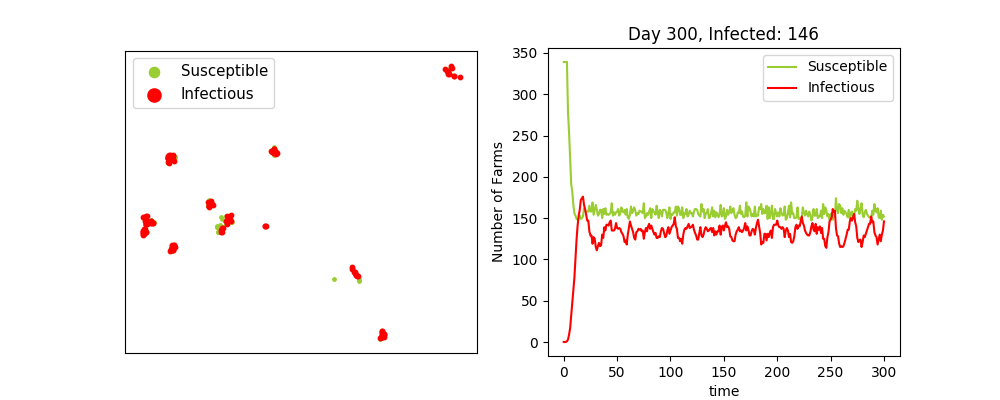

In [118]:
for i in range(1):
#Choose initial cases
       
    t = 0
    A = np.zeros(shape=(N,5)) 

    initial1 = random.randint(0,N-1)
    initial2 = (initial1+1)%N
    initial3 = (initial2+1)%N
    
    infect_cow = np.zeros(N)
    infect_sheep = np.zeros(N)
    I = np.zeros(N)
    
    I[initial1] = 1
    I[initial2] = 1
    I[initial3] = 1

    
    A[initial1, ] = [initial1, 0, s[initial1], r[initial1], q[initial1]]
    A[initial2, ] = [initial2, 0, s[initial2], r[initial2], q[initial1]]
    A[initial3, ] = [initial3, 0, s[initial3], r[initial3], q[initial1]]
    
    infectind = [i for i in range(np.size(I)) if I[i]==2]
    susceptind = [i for i in range(np.size(I)) if I[i] ==0]
    
    
    Inf=[len(infectind)]
    Sus = [len(susceptind)]
    time_plot=[0]
    %matplotlib notebook
    start_time = time.time()
    fig = plt.figure(figsize = (10,4))
    ax = fig.add_subplot(121)
    ax1 = fig.add_subplot(122)
    plt.ion

    fig.show()
    fig.canvas.draw()
    
    while t<300:
        
        ##################################### BETWEEN FARM INFECTIONS ###########################
        t = t + 1
        
        beta = np.zeros(N)
        beta1 = nu*cattle**chi + sheep**chi
#         beta1 = nu*(xi*(cattle)**chi + (sheep)**chi)
        for j in range(0,N):
            beta[j] = beta1[j]*(np.sum((zeta*(cattle[I==2]**chi) +(sheep[I==2]**chi))*kerneldist[I==2, j]))

        prob_inf = (1 - np.exp(-beta)) 
        unif = np.random.uniform(0, 1, N)
        
        ####immunity####
        for i in range(N):
            if (I[i] == 3):
                prob_inf[i] = 0
            
        for i in range(0,N):
            if (unif[i] <= prob_inf[i] and I[i] == 0):
                I[i] =  1
                A[i, ] = [i, t, s[i], r[i], q[i]]

        ####################################### EXPOSED TO INFECTIOUS ##########################

        inf = A[:,0][A[:,1] + A[:,2] == t] #Move to I state once latent period is over
        I[inf.astype(np.int64)] = 2
        
        ######################################## IMMUNITY #####################################
        
#         rem = A[:,0][A[:,1] + A[:,2] + A[:,3] == t] #Move to IM state once infectious period is over
#         I[rem.astype(np.int64)] = 3
        
#         immune = A[:,0][A[:,1] + A[:,2] + A[:,3] + A[:,4] == t] #Move to S state once immune period is over
#         I[immune.astype(np.int64)] = 0
#         A[immune.astype(np.int64), ] = [0,0,0,0,0]
        
    
        ####################################### NO IMMUNITY ##################################
        
        rem = A[:,0][A[:,1] + A[:,2] + A[:,3] == t] #Move to S state once infectious period is over
        A[rem.astype(np.int64), ] = [0,0,0,0,0]
        I[rem.astype(np.int64)] = 0
        
        
        ######################################## PLOTS #######################################
        
        infectind = [i for i in range(np.size(I)) if I[i]==2]
        susceptind = [i for i in range(np.size(I)) if I[i]==0]

        Inf.append(len(infectind))
        Sus.append(len(susceptind))
        
        time_plot.append(t)

        xinfectplot = xcoord[infectind]
        yinfectplot = ycoord[infectind]
        xsusceptplot = xcoord[susceptind]
        ysusceptplot = ycoord[susceptind]


        ax.clear()
        
        ax1.clear()
       
    
        ax1.plot(time_plot,Sus,label='Susceptible', c='yellowgreen')
        ax1.plot(time_plot,Inf,label='Infectious', c='r')
        plt.xlabel('time')
        plt.ylabel('Number of Farms')
        ax1.legend()
        
        
        ax.scatter(xsusceptplot, ysusceptplot, c='yellowgreen', marker='o', s=6, label='Susceptible')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.scatter(xinfectplot, yinfectplot, c='r', marker='o', s=10, label='Infectious')
        ax.axis([0, np.max(xcoord), 0, np.max(ycoord)])

        plt.title('Day {}, Infected: {}'.format(t, np.size(xinfectplot)),fontsize = 12)
        ax.axis('scaled')
        ax.legend(loc = 'upper left', fontsize = 10.8,  markerscale= 3)

        
        
        fig.canvas.draw()


# METAPOPULATION, NO ATTRIBUTES,  NO VACCINES, IMMUNITY

<IPython.core.display.Javascript object>


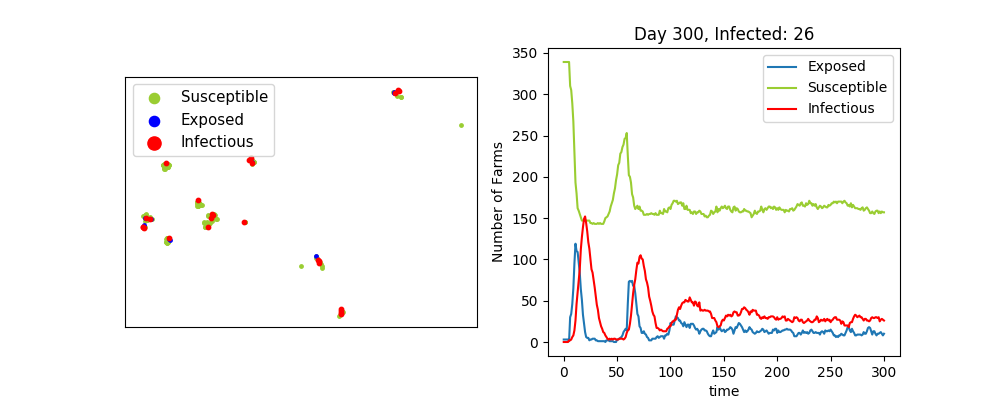

In [119]:
for i in range(1):
#Choose initial cases
       
    t = 0
    A = np.zeros(shape=(N,5))  

    initial1 = random.randint(0,N-1)
    initial2 = (initial1+1)%N
    initial3 = (initial2+1)%N
    
    I = np.zeros(N)
    I[initial1] = 1
    I[initial2] = 1
    I[initial3] = 1
    
    A[initial1, ] = [initial1, 0, s[initial1], r[initial1], q[initial1]]
    A[initial2, ] = [initial2, 0, s[initial2], r[initial2], q[initial2]]
    A[initial3, ] = [initial3, 0, s[initial3], r[initial3], q[initial3]]
    
    infectind = [i for i in range(np.size(I)) if I[i]==2]
    susceptind = [i for i in range(np.size(I)) if I[i] ==0]
    exposedind = [i for i in range(np.size(I)) if I[i] ==1]
    
    infect_cow = np.zeros(N)
    infect_sheep = np.zeros(N)
    
    Inf=[len(infectind)]
    Sus = [len(susceptind)]
    Exp = [len(exposedind)]
    time_plot=[0]
    %matplotlib notebook
    start_time = time.time()
    fig = plt.figure(figsize = (10,4))
    ax = fig.add_subplot(121)
    ax1 = fig.add_subplot(122)
    plt.ion

    fig.show()
    fig.canvas.draw()
    
    while t<300:
        
        t = t + 1
        
     #################################### WITHIN FARM INFECTION ######################################
        
        for farm in infectind:
            Num_livestock = infect_cow[farm] + infect_sheep[farm]
            λ = 0.1
            inf = 1-((1-λ)**Num_livestock) #probability of infecting one animal
            for animals in range(int(cattle[farm]+sheep[farm])):
                p_beta = np.random.uniform(0,1)
                if p_beta<inf:
                    if (random.random() < 0.5 and sheep[farm]>=1 and infect_sheep[farm]<sheep[farm]):
                        infect_sheep[farm] += 1
                    elif (cattle[farm]>=1 and infect_cow[farm]<cattle[farm]):
                        infect_cow[farm] +=1
    

        
       #################################### BETWEEN FARM INFECTION ######################################
        
        beta1 = nu*(cattle-infect_cow)**chi + (sheep-infect_sheep)**chi
#         beta1 = nu*(xi*(cattle-infect_cow)**chi + (sheep-infect_sheep)**chi)
        beta = np.zeros(N)

        for j in range(0,N):
            beta[j] = beta1[j]*(np.sum((zeta*(infect_cow[I==2]**chi) +(infect_sheep[I==2]**chi))*kerneldist[I==2, j]))
       
        prob_inf = (1 - np.exp(-beta)) 
        unif = np.random.uniform(0, 1, N)
        
        ####immunity####
        for i in range(N):
            if (I[i] == 3):
                prob_inf[i] = 0
            
        for i in range(0,N):
            if (unif[i] <= prob_inf[i] and I[i] == 0):
                I[i] =  1
                A[i, ] = [i, t, s[i], r[i], q[i]]
            
        #########################################################################################################
        ######################################## UPDATE STATES ##################################################
        #########################################################################################################
        
        ###################################### EXPOSED TO INFECTIOUS ###########################################
        inf = A[:,0][A[:,1] + A[:,2] == t]
        I[inf.astype(np.int64)] = 2
        
        ####################### UPDATE NUMBER OF INFECTED ANIMALS WITHIN AN INFECTIOUS FARM #####################
        for i in inf:
            i = int(i)
            if (random.random() < 0.5 and sheep[i]>=1 and infect_sheep[i]<sheep[i]):
                infect_sheep[i] += 1
            elif (cattle[i]>=1 and infect_cow[i]<cattle[i]):
                infect_cow[i] +=1
                
        ########################################### NO IMMUNITY #################################################
       
#         rem = A[:,0][A[:,1] + A[:,2] + A[:,3] == t] #Move to S state once infectious period is over
#         infect_sheep[rem.astype(np.int64)] = 0
#         infect_cow[rem.astype(np.int64)] = 0
#         I[rem.astype(np.int64)] = 0
        
#         ### WITHIN FARM RECOVERY ###
#         infected = [i for i in range(N) if (infect_cow+infect_sheep)[i]>0]
#         for farm in infected:
#             mu = 0.05
#             recover = np.random.uniform(0,1)
#             for animals in range(int(infect_cow[farm]+infect_sheep[farm])):
#                 if recover < mu and (infect_sheep[farm]+infect_cow[farm]) >=1 :
#                     if (random.random() < 0.5 and infect_sheep[farm]>=1 ):
#                         infect_sheep[farm] -= 1
#                     elif infect_cow[farm]>=1: 
#                         infect_cow[farm] -= 1
#                     if infect_sheep[farm]+infect_cow[farm] ==0: 
#                         I[farm] = 0
        
        ######################################## IMMUNITY #####################################
        
        rem = A[:,0][A[:,1] + A[:,2] + A[:,3] == t] #Move to IM state once infectious period is over
        I[rem.astype(np.int64)] = 3
        
        immune = A[:,0][A[:,1] + A[:,2] + A[:,3] + A[:,4] == t] #Move to S state once immune period is over
        I[immune.astype(np.int64)] = 0
        A[immune.astype(np.int64), ] = [0,0,0,0,0]
        ### WITHIN FARM RECOVERY ###
        infected = [i for i in range(N) if (infect_cow+infect_sheep)[i]>0]
        for farm in infected:
            mu = 0.05
            recover = np.random.uniform(0,1)
            for animals in range(int(infect_cow[farm]+infect_sheep[farm])):
                if recover < mu and (infect_sheep[farm]+infect_cow[farm]) >=1 :
                    if (random.random() < 0.5 and infect_sheep[farm]>=1 ):
                        infect_sheep[farm] -= 1
                    elif infect_cow[farm]>=1: 
                        infect_cow[farm] -= 1
                    if infect_sheep[farm]+infect_cow[farm] ==0: 
                        I[farm] = 3


        ##################################### PLOTS ################################################


        infectind = [i for i in range(np.size(I)) if I[i]==2]
        susceptind = [i for i in range(np.size(I)) if I[i]==0]
        exposedind = [i for i in range(np.size(I)) if I[i] ==1]
        Inf.append(len(infectind))
        Sus.append(len(susceptind))
        Exp.append(len(exposedind))
        time_plot.append(t)


        xexposedplot = xcoord[exposedind]
        yexposedplot = ycoord[exposedind]
        xinfectplot = xcoord[infectind]
        yinfectplot = ycoord[infectind]
        xsusceptplot = xcoord[susceptind]
        ysusceptplot = ycoord[susceptind]


        ax.clear()
        
        ax1.clear()
       
        ax1.plot(time_plot, Exp, label = 'Exposed')
        ax1.plot(time_plot,Sus,label='Susceptible', c='yellowgreen')
        ax1.plot(time_plot,Inf,label='Infectious', c='r')
        plt.xlabel('time')
        plt.ylabel('Number of Farms')
        ax1.legend()
        
        
        ax.scatter(xsusceptplot, ysusceptplot, c='yellowgreen', marker='o', s=6, label='Susceptible')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.scatter(xexposedplot, yexposedplot, c ='b', marker = 'o', s=6, label = 'Exposed')
        ax.scatter(xinfectplot, yinfectplot, c='r', marker='o', s=10, label='Infectious')
        ax.axis([0, np.max(xcoord), 0, np.max(ycoord)])

        plt.title('Day {}, Infected: {}'.format(t, np.size(xinfectplot)),fontsize = 12)
        ax.axis('scaled')
        ax.legend(loc = 'upper left', fontsize = 10.8,  markerscale= 3)

        
        
        fig.canvas.draw()

# things
- found for every farm that said they shared equipment, milk, water, grazing, found all farms in a 10km euclidean distance from them and put a 1 - IS 10KM A GOOD GUESS?, (going off they wouldn't go more than 4km for water)
- did this for contact_animal and people but put no restriction as they can be at markets - SHOULD WE ADD A DISTANCE
- need to fit for a1-a7, assumed them all to be 1 for now (BAD ASSUMPTION)
- see if any attributes are correlated, reject them
- Then I multiplied each column (which corresponds to a farm j for all i, transmission_matrix[:,j]) by the number of livestock on that farm, with the $\nu$ and $\chi$ terms. So this matrix contains number of livestock on infected farms:

When we calculate


$\beta[j]$ = Number_livestock_on_j x Tranmission_matrix_row_j_all_infected_farms_column x
Kerneldist_distance_between_rows_of_all_infected_farms_and_column_j


In [120]:
CompleteData.columns.values
a1 = 1
a2 = 1
a3 = 1
a4 = 1
a5 =1 
a6 =1
a7 =1
transmission_matrix = (a1*shares_equipment+
 a2*shares_water+
 a3*shares_grazing + 
 a4*shares_milk + 
 a5*shares_vet + 
 a6*contactanimal + 
 a7*contacthuman)


# METAPOPULATION, ATTRIBUTES, CHOICE IMMUNITY, NO VACCINES

<IPython.core.display.Javascript object>


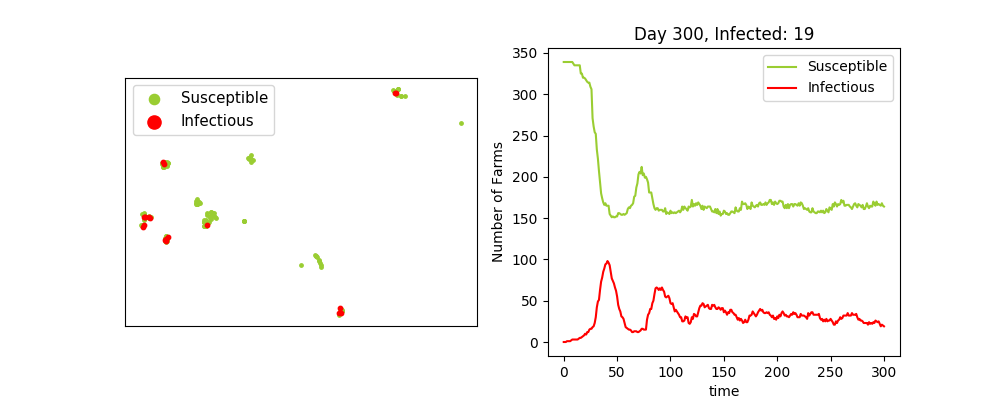

In [122]:
for i in range(1):
#Choose initial cases
       
    t = 0
    A = np.zeros(shape=(N,5)) 
    numInf = np.zeros(10000)  

    initial1 = random.randint(0,N-1)
    initial2 = (initial1+1)%N
    initial3 = (initial2+1)%N
    
    infect_cow = np.zeros(N)
    infect_sheep = np.zeros(N)
    I = np.zeros(N)
    
    I[initial1] = 1
    I[initial2] = 1
    I[initial3] = 1
        
    A[initial1, ] = [initial1, 0, s[initial1], r[initial1], q[initial1]]
    A[initial2, ] = [initial2, 0, s[initial2], r[initial2], q[initial2]]
    A[initial3, ] = [initial3, 0, s[initial3], r[initial3], q[initial3]]
    
    infectind = [i for i in range(np.size(I)) if I[i]==2]
    susceptind = [i for i in range(np.size(I)) if I[i] ==0]
    
    Inf=[len(infectind)]
    Sus = [len(susceptind)]
    time_plot=[0]
    %matplotlib notebook
    start_time = time.time()
    fig = plt.figure(figsize = (10,4))
    ax = fig.add_subplot(121)
    ax1 = fig.add_subplot(122)
    plt.ion

    fig.show()
    fig.canvas.draw()
    
    while t<300:
        
        t= t+1
        
        ######################################### WITHIN FARM #############################################
        for farm in infectind:
            Num_livestock = infect_cow[farm] + infect_sheep[farm]
            λ = 0.1
            inf = 1-((1-λ)**Num_livestock) #probability of infecting one animal
            for animals in range(int(cattle[farm]+sheep[farm])):
                p_beta = np.random.uniform(0,1)
                if (p_beta<inf) and (infect_sheep[farm]+infect_cow[farm])<=Num_livestock:
                    if (random.random() < 0.5 and sheep[farm]>=1 and infect_sheep[farm]<sheep[farm]):
                        infect_sheep[farm] += 1
                    elif (cattle[farm]>=1 and infect_cow[farm]<cattle[farm]):
                        infect_cow[farm] +=1
    

        
        
        ################################# BETWEEN FARM WITH ATTRIBUTES #####################################

        transmission_matrix = (a1*shares_equipment+ 
        a2*shares_water+
        a3*shares_grazing + 
        a4*shares_milk + 
        a5*shares_vet + 
        a6*contactanimal + 
        a7*contacthuman)

        beta = np.zeros(N)
#         beta1 = nu*(xi*(cattle-infect_cow)**chi + (sheep-infect_sheep)**chi)
        beta1 = nu*(cattle-infect_cow)**chi + (sheep-infect_sheep)**chi 
#         beta3 = nu*(xi*(infect_cow)**chi+infect_sheep**chi)
        beta3 = nu*(infect_cow)**chi + infect_sheep**chi
    
        for i in range(N):
            transmission_matrix[:,i] *= (beta3)[i] #tranmission matrix is the infected ones
        for j in range(0,N):
            beta[j] = beta1[j]*np.matrix(transmission_matrix)[j,I==2]*np.matrix(kerneldist)[I == 2, j]

        prob_inf = (1 - np.exp(-beta)) #why is there a 5 here?
        unif = np.random.uniform(0, 1, N)
        
        ### immunity ###
        for i in range(N):
            if (I[i] == 3):
                prob_inf[i] = 0
        for i in range(0,N):
            if (unif[i] <= prob_inf[i] and I[i] == 0):
                I[i] =  1
                A[i, ] = [i, t, s[i], r[i], q[i]]
                

        #########################################################################################################
        ######################################## UPDATE STATES ##################################################
        #########################################################################################################
        
        ###################################### EXPOSED TO INFECTIOUS ############################################
        
        inf = A[:,0][A[:,1] + A[:,2] == t] #Move to I state once latent period is over
        I[inf.astype(np.int64)] = 2
        
        ####################### UPDATE NUMBER OF INFECTED ANIMALS WITHIN AN INFECTIOUS FARM #####################

        for i in inf:
            i = int(i)
            if (random.random() < 0.5 and sheep[i]>=1 and infect_sheep[i]<sheep[i]):
                infect_sheep[i] += 1
            elif (cattle[i]>=1 and infect_cow[i]<cattle[i]):
                infect_cow[i] +=1
        ########################################### NO IMMUNITY #################################################
        
#         rem = A[:,0][A[:,1] + A[:,2] + A[:,3] == t] #Move to S state once infectious period is over
#         infect_sheep[rem.astype(np.int64)] = 0
#         infect_cow[rem.astype(np.int64)] = 0
#         A[rem.astype(np.int64), ] = [0,0,0,0,0]
#         I[rem.astype(np.int64)] = 0
        
#         infected = [i for i in range(N) if (infect_cow+infect_sheep)[i]>0]
#         for farm in infected:
#             mu = 0.05
#             recover = np.random.uniform(0,1)
#             for animals in range(int(infect_cow[farm]+infect_sheep[farm])):
#                 if recover < mu and (infect_sheep[farm]+infect_cow[farm]) >=1 :
#                     if (random.random() < 0.5 and infect_sheep[farm]>=1 ):
#                         infect_sheep[farm] -= 1
#                     elif infect_cow[farm]>=1: 
#                         infect_cow[farm] -=1
#                     if infect_sheep[farm]+infect_cow[farm] ==0: #farm has recovered before its end period
#                         I[farm] = 0

        ############################################ IMMUNITY ##################################################
        
        rem = A[:,0][A[:,1] + A[:,2] + A[:,3] == t] #Move to IM state once infectious period is over
        I[rem.astype(np.int64)] = 3
        
        immune = A[:,0][A[:,1] + A[:,2] + A[:,3] + A[:,4] == t] #Move to S state once immune period is over
        I[immune.astype(np.int64)] = 0
        A[immune.astype(np.int64), ] = [0,0,0,0,0]
        
        ### WITHIN FARM RECOVERY ###
        infected = [i for i in range(N) if (infect_cow+infect_sheep)[i]>0]
        for farm in infected:
            mu = 0.05
            recover = np.random.uniform(0,1)
            for animals in range(int(infect_cow[farm]+infect_sheep[farm])):
                if recover < mu and (infect_sheep[farm]+infect_cow[farm]) >=1 :
                    if (random.random() < 0.5 and infect_sheep[farm]>=1 ):
                        infect_sheep[farm] -= 1
                    elif infect_cow[farm]>=1: 
                        infect_cow[farm] -= 1
                    if infect_sheep[farm]+infect_cow[farm] ==0: 
                        I[farm] = 3


        ##################################### PLOTS ################################################
        
        infectind = [i for i in range(np.size(I)) if I[i]==2]
        susceptind = [i for i in range(np.size(I)) if I[i]==0]

        Inf.append(len(infectind))
        Sus.append(len(susceptind))
        
        time_plot.append(t)



        xinfectplot = xcoord[infectind]
        yinfectplot = ycoord[infectind]
        xsusceptplot = xcoord[susceptind]
        ysusceptplot = ycoord[susceptind]


        ax.clear()
        
        ax1.clear()
       
    
        ax1.plot(time_plot,Sus,label='Susceptible', c='yellowgreen')
        ax1.plot(time_plot,Inf,label='Infectious', c='r')
        plt.xlabel('time')
        plt.ylabel('Number of Farms')
        ax1.legend()
        
        
        ax.scatter(xsusceptplot, ysusceptplot, c='yellowgreen', marker='o', s=6, label='Susceptible')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.scatter(xinfectplot, yinfectplot, c='r', marker='o', s=10, label='Infectious')
        ax.axis([0, np.max(xcoord), 0, np.max(ycoord)])

        plt.title('Day {}, Infected: {}'.format(t, np.size(xinfectplot)),fontsize = 12)
        ax.axis('scaled')
        ax.legend(loc = 'upper left', fontsize = 10.8,  markerscale= 3)

        
        
        fig.canvas.draw()


# Farm Costs

In [22]:
farm_cost = np.zeros(342)
for i in range(0,342):
    farm_cost[i] = 150*sheep[i] + 150*cattle[i]

CompleteData['cost'] = farm_cost

In [23]:
RingVac = 0.5
vac = np.zeros(342)

# Add an immunity period
ADD ABOUT 1month and 1/2

in my code, beta1 = $\eta \text{cattle}^{\chi} + \text{sheep}^{\chi}$ 

in Bens code, beta1 = $\eta (\xi \text{cattle}^{\chi} + \text{sheep}^{\chi})$

In [63]:
q = np.random.negative_binomial(30, 30/60, 342) #Draw immune periods
np.mean(q)

29.5906432748538

# METAPOPULATION, ATTRIBUTES, IMMUNITY, VACCINES

<IPython.core.display.Javascript object>


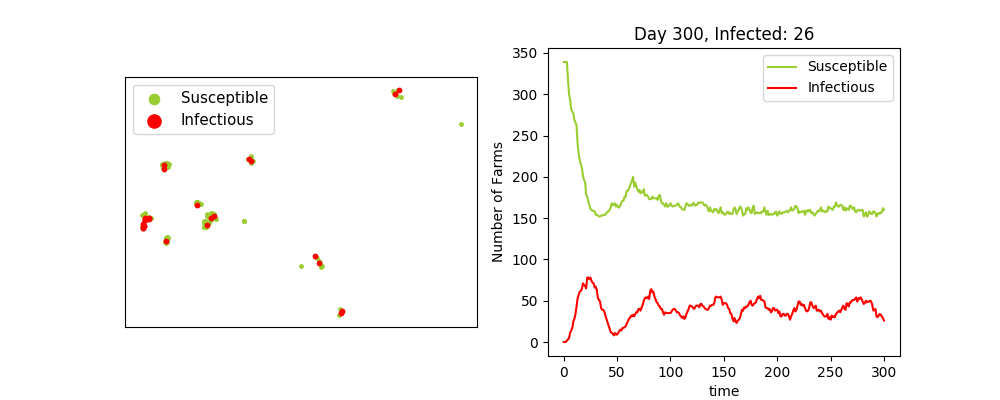

In [85]:
for i in range(1):
#Choose initial cases
    t = 0
    cost = np.zeros(N)
    RingVac = 0.5
    A = np.zeros(shape=(N,7))     
    A[:,0] = -1 
    vac = np.zeros(N)   
    
    numInf = np.zeros(10000)  

    initial1 = random.randint(0,N-1)
    initial2 = (initial1+1)%N
    initial3 = (initial2+1)%N
    
    infect_cow = np.zeros(N)
    infect_sheep = np.zeros(N)
    I = np.zeros(N)
    bet2 = []
    I[initial1] = 1
    I[initial2] = 1
    I[initial3] = 1
    
    A[initial1, ] = [initial1, 0, s[initial1], r[initial1], q[initial1], vac[initial1], epsilon[initial1]]
    A[initial2, ] = [initial2, 0, s[initial2], r[initial2], q[initial2], vac[initial2], epsilon[initial2]]
    A[initial3, ] = [initial3, 0, s[initial3], r[initial3], q[initial3], vac[initial3], epsilon[initial3]]
    
    infectind = [i for i in range(np.size(I)) if I[i]==2]
    susceptind = [i for i in range(np.size(I)) if I[i] ==0]
    exposedind = [i for i in range(np.size(I)) if I[i] == 1]
    immuneind = [i for i in range(np.size(I)) if I[i] ==3]
    
    Inf=[len(infectind)]
    Sus = [len(susceptind)]
    Exp = [len(exposedind)]
    Imm = [len(immuneind)]
    
    time_plot=[0]
    %matplotlib notebook
    start_time = time.time()
    fig = plt.figure(figsize = (10,4))
    ax = fig.add_subplot(121)
    ax1 = fig.add_subplot(122)
    plt.ion

    fig.show()
    fig.canvas.draw()
    
    while t<300:
        
        t = t+1
        ################################## Reintroduction infection #################################
#         if t%60 == 0:
#             newlyinfected = random.randint(0,N-1)
#             I[newlyinfected] = 2
#             A[newlyinfected, ] = [newlyinfected, t, s[newlyinfected], r[newlyinfected], 
#                                   q[newlyinfected], vac[newlyinfected], epsilon[newlyinfected]]
        
        ################################### WITHIN FARM INFECTION ####################################
        for farm in infectind:
            Num_livestock = infect_cow[farm] + infect_sheep[farm]
            λ = 0.1
            inf = 1-((1-λ)**Num_livestock) 
            for animals in range(int(cattle[farm]+sheep[farm])):
                p_beta = np.random.uniform(0,1)
                if (p_beta<inf) and (infect_sheep[farm]+infect_cow[farm])<=Num_livestock:
                    if (random.random() < 0.5 and sheep[farm]>=1 and infect_sheep[farm]<sheep[farm]):
                        infect_sheep[farm] += 1
                    elif (cattle[farm]>=1 and infect_cow[farm]<cattle[farm]):
                        infect_cow[farm] +=1
    
        ################################# BETWEEN FARM INFECTION #####################################
        transmission_matrix = (a1*shares_equipment+ #need to clear and update this everytime
        a2*shares_water+
        a3*shares_grazing + 
        a4*shares_milk + 
        a5*shares_vet + 
        a6*contactanimal + 
        a7*contacthuman)


        beta = np.zeros(N)
        beta1 = nu*(cattle-infect_cow)**chi + (sheep-infect_sheep)**chi
#         beta1 = nu*(xi*(cattle-infect_cow)**chi + (sheep-infect_sheep)**chi)
        beta3 = nu*(infect_cow)**chi + infect_sheep**chi
#         beta3 = nu*(xi*(infect_cow)**chi+infect_sheep**chi

#         ##### EFFICACY OF VACCINE #####
        for i in range(0,N):
            if (vac[i] == 1):
               beta1[i] = epsilon[i]*beta1[i]
            
        for i in range(N):
            transmission_matrix[:,i] *= (beta3)[i]
        for j in range(0,N):
            beta[j] = beta1[j]*np.matrix(transmission_matrix)[j,I==2]*np.matrix(kerneldist)[I == 2, j]

        prob_inf = (1 - np.exp(-beta))
        unif = np.random.uniform(0, 1, N)
        
        ### immunity ###
        for i in range(N):
            if (I[i] == 3):
                prob_inf[i] = 0
        for i in range(0,N):
            if (unif[i] <= prob_inf[i] and I[i] == 0):
                I[i] =  1
                A[i, ] = [i, t, s[i], r[i], q[i], vac[i], epsilon[i]]

        #########################################################################################################
        ######################################## UPDATE STATES ##################################################
        #########################################################################################################
        
        ###################################### EXPOSED TO INFECTIOUS ############################################
        
        inf = A[:,0][A[:,1] + A[:,2] == t] 
        I[inf.astype(np.int64)] = 2
        
        ####################### UPDATE NUMBER OF INFECTED ANIMALS WITHIN AN INFECTIOUS FARM #####################
        
        for i in inf: 
            i = int(i)
            if (random.random() < 0.5 and sheep[i]>=1 and infect_sheep[i]<sheep[i]):
                infect_sheep[i] += 1
            elif (cattle[i]>=1 and infect_cow[i]<cattle[i]):
                infect_cow[i] +=1
        
        ########################################### RING VACCINATION ###########################################
        
        for i in range(len(inf)):
           eff = np.random.normal(0.5, 0.2)
           n = [k for k in range(len(I)) if dist[inf[i].astype(np.int64), k] < 10]
           for j in range(len(n)):
              m = n[j] 
              if (I[m] != 2 and vac[m] == 0):
                 vac[m] = 1
                 epsilon[m] = eff
                 cost = cost + farm_cost[m]
                    
        ######################################### NO IMMUNITY ###################################################
        
#         rem = A[:,0][A[:,1] + A[:,2] + A[:,3] == t] #Move to S state once infectious period is over
#         infect_sheep[rem.astype(np.int64)] = 0
#         infect_cow[rem.astype(np.int64)] = 0
#         A[rem.astype(np.int64), ] = [0,0,0,0,0,0,0]
#         I[rem.astype(np.int64)] = 0

#         infected = [i for i in range(N) if (infect_cow+infect_sheep)[i]>0]
#         for farm in infected:
#             mu = 0.05
#             recover = np.random.uniform(0,1)
#             for animals in range(int(infect_cow[farm]+infect_sheep[farm])):
#                 if recover < mu and (infect_sheep[farm]+infect_cow[farm]) >=1 :
#                     if (random.random() < 0.5 and infect_sheep[farm]>=1 ):
#                         infect_sheep[farm] -= 1
#                     elif infect_cow[farm]>=1: 
#                         infect_cow[farm] -=1
#                     if infect_sheep[farm]+infect_cow[farm] ==0: #farm has recovered before its end period
#                         I[farm] = 0

                
        ######################################### IMMUNITY #######################################################
        

        rem = A[:,0][A[:,1] + A[:,2] + A[:,3] == t] #Move to IM state once infectious period is over
        I[rem.astype(np.int64)] = 3
        infect_sheep[rem.astype(np.int64)] = 0
        infect_cow[rem.astype(np.int64)] = 0
        
        immune = A[:,0][A[:,1] + A[:,2] + A[:,3] + A[:,4] == t] #Move to S state once immune period is over
        I[immune.astype(np.int64)] = 0
        A[immune.astype(np.int64), ] = [0,0,0,0,0,0, 0]
        
        #### WITHIN FARM RECOVERY ####
        infected = [i for i in range(N) if (infect_cow+infect_sheep)[i]>0]
        for farm in infected:
            mu = 0.05
            recover = np.random.uniform(0,1)
            for animals in range(int(infect_cow[farm]+infect_sheep[farm])):
                if recover < mu and (infect_sheep[farm]+infect_cow[farm]) >=1 :
                    if (random.random() < 0.5 and infect_sheep[farm]>=1 ):
                        infect_sheep[farm] -= 1
                    elif infect_cow[farm]>=1: 
                        infect_cow[farm] -=1
                    if infect_sheep[farm]+infect_cow[farm] ==0: 
                        I[farm] = 3
        
        ############################################### PLOTS #####################################################
        
        infectind = [i for i in range(np.size(I)) if I[i]==2]
        susceptind = [i for i in range(np.size(I)) if I[i]==0]

        Inf.append(len(infectind))
        Sus.append(len(susceptind))
        
        time_plot.append(t)



        xinfectplot = xcoord[infectind]
        yinfectplot = ycoord[infectind]
        xsusceptplot = xcoord[susceptind]
        ysusceptplot = ycoord[susceptind]


        ax.clear()
        
        ax1.clear()
       
    
        ax1.plot(time_plot,Sus,label='Susceptible', c='yellowgreen')
        ax1.plot(time_plot,Inf,label='Infectious', c='r')
        plt.xlabel('time')
        plt.ylabel('Number of Farms')
        ax1.legend()
        
        
        ax.scatter(xsusceptplot, ysusceptplot, c='yellowgreen', marker='o', s=6, label='Susceptible')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.scatter(xinfectplot, yinfectplot, c='r', marker='o', s=10, label='Infectious')
        ax.axis([0, np.max(xcoord), 0, np.max(ycoord)])

        
        plt.title('Day {}, Infected: {}'.format(t, np.size(xinfectplot)),fontsize = 12)
        ax.axis('scaled')
        ax.legend(loc = 'upper left', fontsize = 10.8,  markerscale= 3)

        
        
        fig.canvas.draw()

# Add vaccinated class + capacity

In [96]:
tr = np.random.negative_binomial(14, 14/28, 342) #Draw immune periods
np.mean(tr)
v = np.random.negative_binomial(30, 30/60, N)

<IPython.core.display.Javascript object>


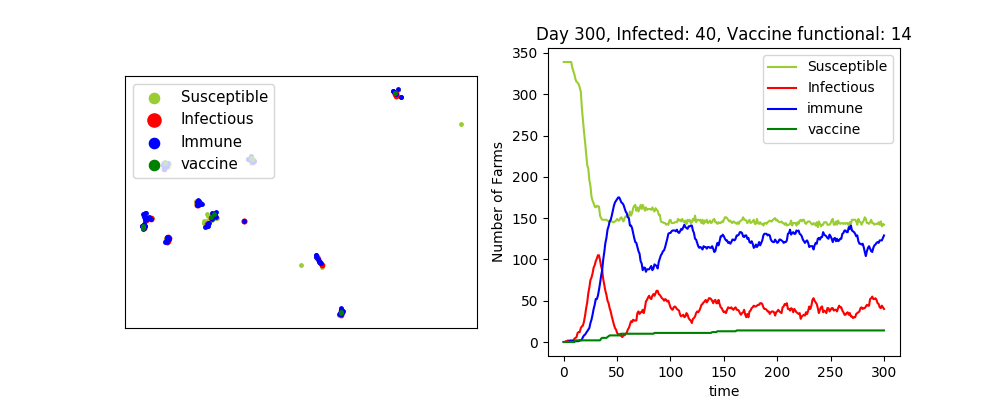

/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:153: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


In [116]:
for i in range(1):
#Choose initial cases
    t = 0
    cost = np.zeros(N)
    RingVac = 0.5
    A = np.zeros(shape=(N,8))     
    A[:,0] = -1 
    vac = np.zeros(N)   
    
    
    initial1 = random.randint(0,N-1)
    initial2 = (initial1+1)%N
    initial3 = (initial2+1)%N
    
    infect_cow = np.zeros(N)
    infect_sheep = np.zeros(N)
    I = np.zeros(N)
    bet2 = []
    I[initial1] = 1
    I[initial2] = 1
    I[initial3] = 1
    
    A[initial1, ] = [initial1, 0, s[initial1], r[initial1], tr[initial1], q[initial1], 0, v[initial1]]
    A[initial2, ] = [initial2, 0, s[initial2], r[initial2], tr[initial2], q[initial2], 0, v[initial2]]
    A[initial3, ] = [initial3, 0, s[initial3], r[initial3], tr[initial3], q[initial1], 0, v[initial3]]
    
    infectind = [i for i in range(np.size(I)) if I[i]==2]
    susceptind = [i for i in range(np.size(I)) if I[i] ==0]
    exposedind = [i for i in range(np.size(I)) if I[i] == 1]
    immuneind = [i for i in range(np.size(I)) if I[i] ==4]
    vaccineind = [i for i in range(np.size(I)) if I[i]==3]
    
    Inf=[len(infectind)]
    Sus = [len(susceptind)]
    Exp = [len(exposedind)]
    Imm = [len(immuneind)]
    Vac = [len(vaccineind)]
    
    time_plot=[0]
    %matplotlib notebook
    start_time = time.time()
    fig = plt.figure(figsize = (10,4))
    ax = fig.add_subplot(121)
    ax1 = fig.add_subplot(122)
    plt.ion

    fig.show()
    fig.canvas.draw()
    Dose = []
    VAC = []
    travelled = []
    Capacity = 5
    
    while t<300:
        
        t = t+1
        ################################## Reintroduction infection #################################
#         if t%60 == 0:
#             newlyinfected = random.randint(0,N-1)
#             I[newlyinfected] = 2
#             A[newlyinfected, ] = [newlyinfected, t, s[newlyinfected], r[newlyinfected], 
#                                   q[newlyinfected], vac[newlyinfected], epsilon[newlyinfected]]
        
        ################################### WITHIN FARM INFECTION ####################################
        for farm in infectind:
            Num_livestock = infect_cow[farm] + infect_sheep[farm]
            λ = 0.1
            inf = 1-((1-λ)**Num_livestock) 
            for animals in range(int(cattle[farm]+sheep[farm])):
                p_beta = np.random.uniform(0,1)
                if (p_beta<inf) and (infect_sheep[farm]+infect_cow[farm])<=Num_livestock:
                    if (random.random() < 0.5 and sheep[farm]>=1 and infect_sheep[farm]<sheep[farm]):
                        infect_sheep[farm] += 1
                    elif (cattle[farm]>=1 and infect_cow[farm]<cattle[farm]):
                        infect_cow[farm] +=1
    
        ################################# BETWEEN FARM INFECTION #####################################
        transmission_matrix = (a1*shares_equipment+ #need to clear and update this everytime
        a2*shares_water+
        a3*shares_grazing + 
        a4*shares_milk + 
        a5*shares_vet + 
        a6*contactanimal + 
        a7*contacthuman)


        beta = np.zeros(N)
        beta1 = nu*(cattle-infect_cow)**chi + (sheep-infect_sheep)**chi
#         beta1 = nu*(xi*(cattle-infect_cow)**chi + (sheep-infect_sheep)**chi)
        beta3 = nu*(infect_cow)**chi + infect_sheep**chi
#         beta3 = nu*(xi*(infect_cow)**chi+infect_sheep**chi

#
        for i in range(N):
            transmission_matrix[:,i] *= (beta3)[i]
        for j in range(0,N):
            beta[j] = beta1[j]*np.matrix(transmission_matrix)[j,I==2]*np.matrix(kerneldist)[I == 2, j]

        prob_inf = (1 - np.exp(-beta))
        unif = np.random.uniform(0, 1, N)
        
        ### immunity ###
        for i in range(N):
            if (I[i] == 4) or (I[i] == 3):
                prob_inf[i] = 0
        for i in range(0,N):
            if (unif[i] <= prob_inf[i] and I[i] == 0):
                I[i] =  1
                A[i, ] = [i, t, s[i], r[i], tr[i], q[i], 0, v[i]]

        #########################################################################################################
        ######################################## UPDATE STATES ##################################################
        #########################################################################################################
        
        ###################################### EXPOSED TO INFECTIOUS ############################################
        
        inf = A[:,0][A[:,1] + A[:,2] == t] 
        I[inf.astype(np.int64)] = 2
        
        ####################### UPDATE NUMBER OF INFECTED ANIMALS WITHIN AN INFECTIOUS FARM #####################
        
        for i in inf: 
            i = int(i)
            if (random.random() < 0.5 and sheep[i]>=1 and infect_sheep[i]<sheep[i]):
                infect_sheep[i] += 1
            elif (cattle[i]>=1 and infect_cow[i]<cattle[i]):
                infect_cow[i] +=1
        
        ########################################### RING VACCINATION ###########################################


        trig = A[:,0][A[:,1] + A[:,2] + A[:,4] == t] #Move to R state once infectious period is over
        for i in range(len(trig)):
            n = [k for k in range(len(I)) if dist[trig[i].astype(np.int64), k] < 10]
            for j in range(len(n)):
                m = n[j]
                if A[m,6] == 0:
                    VAC = np.append(VAC,m)
                    travelled.append(dist[trig[i].astype(np.int64), m])
        VAC = [x for _,x in sorted(zip([x for x in travelled],VAC))]
        VAC = np.unique(np.array(VAC, dtype=np.int))
        
        if len(VAC)>Capacity:
            cost[VAC[0:Capacity]] += farm_cost[VAC[0:Capacity]]
            eff = np.random.beta(3.8, 9)
            for j in range(len(VAC[0:Capacity])):
                m = n[j]
                A[m,0] = m
                A[m,6] = t
                A[m, 7] = v[m]
                if (I[m] == 0 and np.random.uniform(0,1) < eff):
                    I[m] = 3
            VAC = np.delete(VAC, VAC[0:Capacity])
        else: 
            cost[VAC] += farm_cost[VAC]
            eff = np.random.beta(3.8,9)
            for j in range(len(VAC)):
                m = n[j]
                A[m,0] = m
                A[m, 6] = t
                A[m, 7] = v[m]
                if (I[m] == 0 and np.random.uniform(0,1) <eff):
                    I[m] = 3
            VAC = np.delete(VAC, VAC[0:len(VAC)])
        
        ########################################### vaccine wears off ###########################################
        vaccinate = A[:,0][A[:,6]+A[:,7] == t]
        A[vaccinate.astype(np.int64), 6] = 0
        for j in vaccinate:
            if I[j.astype(np.int64)] == 3:
                I[j.astype(np.int64)] == 0
                    
        ######################################### NO IMMUNITY ###################################################
        
#         rem = A[:,0][A[:,1] + A[:,2] + A[:,3] == t] #Move to S state once infectious period is over
#         infect_sheep[rem.astype(np.int64)] = 0
#         infect_cow[rem.astype(np.int64)] = 0
#         A[rem.astype(np.int64), ] = [0,0,0,0,0,0,0]
#         I[rem.astype(np.int64)] = 0

#         infected = [i for i in range(N) if (infect_cow+infect_sheep)[i]>0]
#         for farm in infected:
#             mu = 0.05
#             recover = np.random.uniform(0,1)
#             for animals in range(int(infect_cow[farm]+infect_sheep[farm])):
#                 if recover < mu and (infect_sheep[farm]+infect_cow[farm]) >=1 :
#                     if (random.random() < 0.5 and infect_sheep[farm]>=1 ):
#                         infect_sheep[farm] -= 1
#                     elif infect_cow[farm]>=1: 
#                         infect_cow[farm] -=1
#                     if infect_sheep[farm]+infect_cow[farm] ==0: #farm has recovered before its end period
#                         I[farm] = 0

                
        ######################################### IMMUNITY #######################################################
        

        rem = A[:,0][A[:,1] + A[:,2] + A[:,3] == t] #Move to IM state once infectious period is over
        I[rem.astype(np.int64)] = 4
        infect_sheep[rem.astype(np.int64)] = 0
        infect_cow[rem.astype(np.int64)] = 0
        
        immune = A[:,0][A[:,1] + A[:,2] + A[:,3] + A[:,5] == t] #Move to S state once immune period is over
        I[immune.astype(np.int64)] = 0
        A[immune.astype(np.int64), ] = [0, 0, 0, 0, 0, 0, 0, 0]
                           
        
        
        #### WITHIN FARM RECOVERY ####
        infected = [i for i in range(N) if (infect_cow+infect_sheep)[i]>0]
        for farm in infected:
            mu = 0.05
            recover = np.random.uniform(0,1)
            for animals in range(int(infect_cow[farm]+infect_sheep[farm])):
                if recover < mu and (infect_sheep[farm]+infect_cow[farm]) >=1 :
                    if (random.random() < 0.5 and infect_sheep[farm]>=1 ):
                        infect_sheep[farm] -= 1
                    elif infect_cow[farm]>=1: 
                        infect_cow[farm] -=1
                    if infect_sheep[farm]+infect_cow[farm] ==0: 
                        I[farm] = 4
        
        ############################################### PLOTS #####################################################
        
        infectind = [i for i in range(np.size(I)) if I[i]==2]
        susceptind = [i for i in range(np.size(I)) if I[i]==0]
        exposedind = [i for i in range(np.size(I)) if I[i] == 1]
        immuneind = [i for i in range(np.size(I)) if I[i] ==4]
        vaccineind = [i for i in range(np.size(I)) if I[i]==3]
        had_dose = [i for i in range(np.size(I)) if A[i,6]>0]
        
        Dose.append(len(had_dose))
        
        Inf.append(len(infectind))
        Sus.append(len(susceptind))
        Exp.append(len(exposedind))
        Imm.append(len(immuneind))
        Vac.append(len(vaccineind))
        time_plot.append(t)



        xinfectplot = xcoord[infectind]
        yinfectplot = ycoord[infectind]
        xsusceptplot = xcoord[susceptind]
        ysusceptplot = ycoord[susceptind]
        xexposeplot = xcoord[exposedind]
        yexposeplot = ycoord[exposedind]
        ximmuneplot = xcoord[immuneind]
        yimmuneplot = ycoord[immuneind]
        xvaccineplot = xcoord[vaccineind]
        yvaccineplot = ycoord[vaccineind]
        ax.clear()
        
        ax1.clear()
       
    
        ax1.plot(time_plot,Sus,label='Susceptible', c='yellowgreen')
        ax1.plot(time_plot,Inf,label='Infectious', c='r')
        ax1.plot(time_plot, Imm, label = 'immune', c='b')
        ax1.plot(time_plot, Vac, label = 'vaccine', c='g')
        plt.xlabel('time')
        plt.ylabel('Number of Farms')
        ax1.legend()
        
        
        ax.scatter(xsusceptplot, ysusceptplot, c='yellowgreen', marker='o', s=6, label='Susceptible')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.scatter(xinfectplot, yinfectplot, c='r', marker='o', s=10, label='Infectious')
        ax.scatter(ximmuneplot, yimmuneplot, c='b', marker='o', s=6, label='Immune')
        ax.scatter(xvaccineplot, yvaccineplot, c='g', marker = 'o', s = 6, label = 'vaccine')
        ax.axis([0, np.max(xcoord), 0, np.max(ycoord)])

        
        plt.title('Day {}, Infected: {}, Vaccine functional: {}'.format(t, np.size(xinfectplot), np.size(xvaccineplot)),fontsize = 12)
        ax.axis('scaled')
        ax.legend(loc = 'upper left', fontsize = 10.8,  markerscale= 3)

        
        
        fig.canvas.draw()